# Set-up

## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.cm import plasma
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm

from scipy.stats import pearsonr, spearmanr

from utils import functional_norm, normalize_curves, month_to_season
from decompose_load import non_blind_separation, decompose_load, decompose_daily_consumption, get_monthly_sectors_consumption
from blind_separation import get_D, get_indicators, get_Y, get_curves_info, process_sector_consumption

colors = sns.color_palette("deep")
sns.set_theme()
pd.options.mode.chained_assignment = None

## Parameters

In [2]:
# arrays_path = f'data/3_output/nmf_results/batch_clean/clean_results_{n_comp}comp_{n_runs}runs.npz'
train_load_path = 'data/daily_curves.csv'
test_load_path = 'data/daily_curves_2023.csv'
train_results_path = "data/lcnmf_ens.npz"
models_path = train_results_path.replace('.npz', '.pkl')

imser_file = 'data/1_input/indicators/IMSER.xlsx'
imcei_file = 'data/1_input/indicators/IMCEI_mensile.xlsx'
enel_files = [
    'data/1_input/indicators/Domestico 2020 e 2021.xlsx', 
    'data/1_input/indicators/Domestico 2022 e 2023.xlsx'
]
consumption_file = 'data/1_input/consumption/consumption.xlsx'

hue_order = {
    'daytype': ['Monday', 'Working day', 'Saturday', 'Holiday'],
    'season': ['Spring', 'Summer', 'Fall', 'Winter']
}

sectors = ['Domestic', 'Industry', 'Services']

indicator = {
    'Domestic': 'Enel',
    'Industry': 'IMCEI',
    'Services': 'IMSER',
}

## Functions

In [3]:
def plot_monthly_cons(Y_pred, Y, sector, train_months, test_months, linewidth=3, figsize=(12, 4), ylim=None, fontsize=18, legend_loc='lower left'):
    fig, ax = plt.subplots(figsize=figsize)

    sns.lineplot(
        data=Y_pred[Y_pred.index.isin(test_months)].reset_index(),
        x='date',
        y=sector,
        color=colors[3],
        label='Predicted',
        errorbar='pi',
        ax=ax,
        # marker='o',
        linewidth=linewidth
    )

    sns.lineplot(
        data=Y_pred[Y_pred.index.isin(train_months)].reset_index(),
        x='date',
        y=sector,
        color='grey',
        label='Fitted',
        errorbar='pi',
        ax=ax,
        # marker='o',
        linewidth=linewidth
    )

    # HOTFIX specific for year 2023
    Y.loc[:, sector].plot(color=colors[0], label='Target', ax=ax, linewidth=linewidth)

    if ylim:
        if isinstance(ylim, dict):
            ax.set_ylim(**ylim)
        else:
            ax.set_ylim(ylim)
    ax.set_ylabel('Consumption [GWh]')
    ax.set_xlabel(None, fontsize=fontsize)
    ax.set_ylabel("Consumption [GWh]", fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=fontsize-2, loc=legend_loc)

    plt.show()

def plot_correlation_yoy(yoy_true, yoy_pred, correlation='Pearson'):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    for i, sector in enumerate(sectors):

        x = yoy_true.loc[:, indicator[sector]]
        y = yoy_pred.loc[:, sector]

        # Calculate correlation and p-value
        if correlation == 'Spearman':
            corr, p_value = spearmanr(x, y)
        else:
            corr, p_value = pearsonr(x, y)

        sns.scatterplot(x=x, y=y, ax=axs[i])

        axs[i].plot([x.min(), x.max()], [x.min(), x.max()], color='grey', linestyle='--', linewidth=1, label="y = x")

        # Display correlation and p-value on the plot
        axs[i].text(0.05, 0.95, f'{correlation} r = {corr:.2f}\np-value = {p_value:.3f}', 
                    fontsize=12, ha='left', va='top', transform=axs[i].transAxes)

        # Customize the plot
        # axs[i].set_title(f"Scatter Plot with Pearson Correlation for {year}")
        axs[i].set_xlabel(f"{indicator[sector]} YoY%")
        axs[i].set_ylabel(f"BSS {sector} YoY%")

    # Set a common title for all subplots
    fig.suptitle(f"{correlation} correlation", fontsize=16)

    # Adjust the layout
    plt.subplots_adjust(wspace=0.3, hspace=0.2)


def plot_profiles(profiles_ens, sector, hue, palette=None, figsize=(10, 6), fontsize=18):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(
        data=profiles_ens.groupby([hue, 'hour', 'model'], as_index=False)[sector].mean(),
        x='hour',
        y=sector,
        errorbar=None,
        ax=ax,
        hue=hue,
        hue_order=hue_order[hue],
        # marker='o',
        linewidth=3,
        palette=palette
    )
    # Set a title for the plot
    # ax.set_title(f'Profile for sector {sector}', fontsize=16)
    ax.set_ylim((0,0.065))
    ax.set_ylabel('Normalised Load', fontsize=fontsize)
    ax.legend(title=None, loc='upper left', fontsize=fontsize-2)
    ax.set_xlabel('Hour', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize
    plt.show()


def plot_decomposed_load(load_df, period, time_column, y_label, ylim, figsize=(20, 6), linewidth=3, fontsize=18):
    fig, ax = plt.subplots(figsize=figsize)

    for i, sector in enumerate(sectors):
        sns.lineplot(
            data=load_df[(load_df[time_column] >= period[0]) & (load_df[time_column] <= period[1])],
            x=time_column,
            y=sector,
            color=colors[i],
            errorbar='pi',
            ax=ax,
            marker='',
            label=sector,
            linewidth=linewidth
        )

    plt.ylim(ylim)

    ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
    ax.set_ylabel(y_label, fontsize=fontsize)  # Y-axis label fontsize
    ax.tick_params(axis='both', which='major', labelsize=fontsize,
                   rotation=45
                   )  # X and Y ticks fontsize

    # Add the legend
    ax.legend(title=None, fontsize=fontsize, title_fontsize=fontsize)
    plt.show()


def plot_aggregated_load(load_df, period, time_column, y_label, ylim, figsize=(20, 6), linewidth=3, fontsize=18):
    fig, ax = plt.subplots(figsize=figsize)
    plot_df = load_df[(load_df[time_column] > period[0]) & (load_df[time_column] < period[1])]
    plot_df['Total load_df'] = plot_df['Domestic'] + plot_df['Industry'] + plot_df['Services']
    sns.lineplot(
        data=plot_df,
        x=time_column,
        y='Total load_df',
        color='grey',
        errorbar=None,
        ax=ax,
        marker='',
        linewidth=linewidth
    )
    plt.ylim(ylim)
    ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
    ax.set_ylabel(y_label, fontsize=fontsize)  # Y-axis label fontsize
    ax.tick_params(axis='both', which='major', labelsize=fontsize,
                   rotation=45
                )  # X and Y ticks fontsize
    plt.show()

# Main

## Read data

In [4]:
train_df = pd.read_csv(train_load_path, index_col=0)
test_df = pd.read_csv(test_load_path, index_col=0)
df = pd.concat([train_df, test_df])
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2021-01-01_Holiday,24.986001,23.811999,21.637000,20.353000,19.526999,19.710000,20.630999,21.374000,21.476001,23.120000,...,26.286000,26.797999,29.402999,30.276001,30.879000,30.785000,29.278000,27.781000,25.231001,22.897000
Italy_2021-01-02_Saturday,22.897000,21.066000,20.098000,19.479001,19.628001,20.179000,22.057000,23.665000,25.416998,27.632999,...,29.591000,30.256001,33.563999,34.974999,35.488000,33.922000,31.566000,29.291000,26.366000,23.792000
Italy_2021-01-03_Holiday,23.792000,21.782999,20.718999,19.991000,19.710998,20.401000,21.539000,22.461000,23.366000,25.735000,...,28.014999,28.608000,31.402001,32.602000,34.002999,33.683000,31.166000,28.950000,26.456999,23.869001
Italy_2021-01-04_Monday,23.869001,21.958999,20.935000,20.653000,20.996000,21.926001,25.264000,30.375001,35.006000,38.855001,...,40.088000,40.025999,42.123001,42.675000,42.545000,40.479002,37.293000,33.952999,30.775001,27.518001
Italy_2021-01-05_Working day,27.518001,25.220001,23.844999,23.238001,23.341001,24.062000,27.387000,32.159999,36.935000,40.043999,...,40.971001,40.879001,43.033000,42.841000,42.022000,40.233000,37.153001,34.007001,30.542000,27.504999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-27_Working day,21.686000,19.714000,18.834000,18.362000,18.458000,19.527000,22.776999,26.962000,30.687999,33.935000,...,33.716999,33.448000,35.718000,36.023000,36.154000,34.695000,32.187000,29.046999,26.000001,23.155001
Italy_2023-12-28_Working day,23.155001,21.268999,20.056001,19.667999,19.638000,20.635000,23.673000,27.638000,31.188998,34.135000,...,33.541000,33.852999,36.306999,36.158000,36.189001,34.751000,32.182001,28.971000,25.710000,22.755001
Italy_2023-12-29_Working day,22.755001,20.792000,19.817999,19.369999,19.352000,20.237999,22.783000,26.304001,29.453000,32.343000,...,31.818000,31.941001,34.263999,34.661000,34.795999,33.152000,30.860000,28.218999,25.332999,22.629000
Italy_2023-12-30_Saturday,22.629000,20.789999,19.718999,19.234000,19.138000,19.780001,21.512001,24.080000,26.029999,28.430001,...,27.979999,28.876998,32.021999,33.344001,34.088999,32.942002,30.398000,28.059000,25.597001,22.839000


In [5]:
# Get train and test period information
test_info = get_curves_info(test_df)
test_months = pd.to_datetime(test_info['year'].astype(str) + '-' + test_info['month'], format='%Y-%m').unique()
train_info = get_curves_info(train_df)
train_months = pd.to_datetime(train_info['year'].astype(str) + '-' + train_info['month'], format='%Y-%m').unique()

# Get information for train + test period
unit_info = get_curves_info(df)

In [6]:
# Load the arrays of the blind separation (train) from the .npz file
data = np.load(train_results_path)
with open(models_path, 'rb') as file:
    model_ens = pickle.load(file)
# Access the arrays
S_ens = data['S_results'] # Could be also retrieved from model_ens
Ctrain_ens = data['C_results'] # Specific to the training data

## Deconvolve load and compute consumption per sectors

Perform non-blind separation of the test (new) data to estimate sources concentrations

In [7]:
X_test = normalize_curves(test_df)
Ctest_ens = non_blind_separation(X_test, model_ens)

100%|██████████| 271/271 [00:32<00:00,  8.47it/s]


In [8]:
# Put all concentrations together
C_ens = np.concatenate((Ctrain_ens, Ctest_ens), axis=0)

In [9]:
K, p, N = S_ens.shape
h = 24 / (p - 1)
# Daily consumptions
E = unit_info['cons']

In [10]:
decomposed_load = decompose_load(C_ens, S_ens, E)
decomposed_load['Domestic'] = decomposed_load['$S_1$'] + decomposed_load['$S_2$']
decomposed_load['Industry'] = decomposed_load['$S_3$']
decomposed_load['Services'] = decomposed_load['$S_4$'] + decomposed_load['$S_5$']
decomposed_load.drop(columns=[f'$S_{k+1}$' for k in range(K)], inplace=True)
decomposed_load['date'] = decomposed_load['datetime'].dt.date
decomposed_load['datetime'] = pd.to_datetime(decomposed_load['datetime'])
decomposed_load

,model,hour,obs,datetime,zone,Domestic,Industry,Services,date
0,0,0.0,Italy_2021-01-01_Holiday,2021-01-01 00:00:00,Italy,18.705119,1.618543,4.864571,2021-01-01
1,0,1.0,Italy_2021-01-01_Holiday,2021-01-01 01:00:00,Italy,17.115438,1.513599,4.673273,2021-01-01
2,0,2.0,Italy_2021-01-01_Holiday,2021-01-01 02:00:00,Italy,16.074620,1.456106,4.461372,2021-01-01
3,0,3.0,Italy_2021-01-01_Holiday,2021-01-01 03:00:00,Italy,15.411188,1.435232,4.267510,2021-01-01
4,0,4.0,Italy_2021-01-01_Holiday,2021-01-01 04:00:00,Italy,14.991609,1.435281,4.255245,2021-01-01
...,...,...,...,...,...,...,...,...,...
7418620,270,20.0,Italy_2023-12-31_Holiday,2023-12-31 20:00:00,Italy,15.673343,1.498228,12.719960,2023-12-31
7418621,270,21.0,Italy_2023-12-31_Holiday,2023-12-31 21:00:00,Italy,13.872352,1.409798,12.620167,2023-12-31
7418622,270,22.0,Italy_2023-12-31_Holiday,2023-12-31 22:00:00,Italy,12.979513,1.250958,11.837614,2023-12-31
7418623,270,23.0,Italy_2023-12-31_Holiday,2023-12-31 23:00:00,Italy,11.896108,1.139348,10.869174,2023-12-31


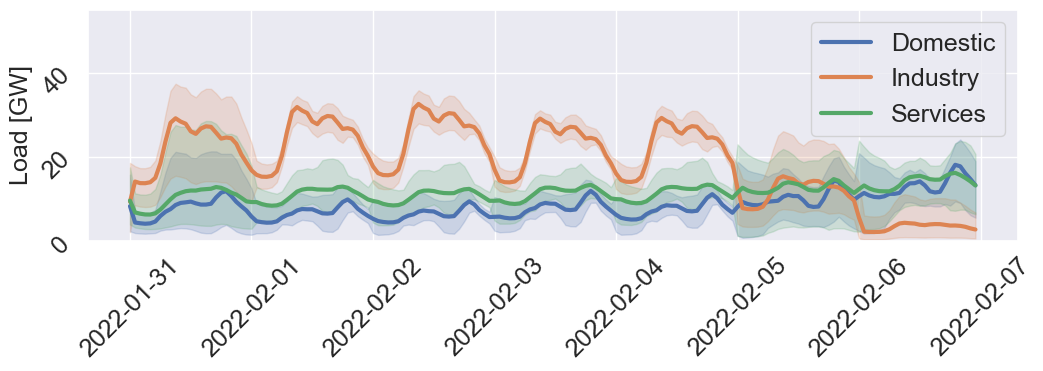

In [11]:
period = ["2022-01-31 00:00:00", "2022-02-06 23:59:00"]
plot_decomposed_load(decomposed_load, period, time_column='datetime', y_label="Load [GW]", ylim=(0, 55), fontsize=18, figsize=(12,3))

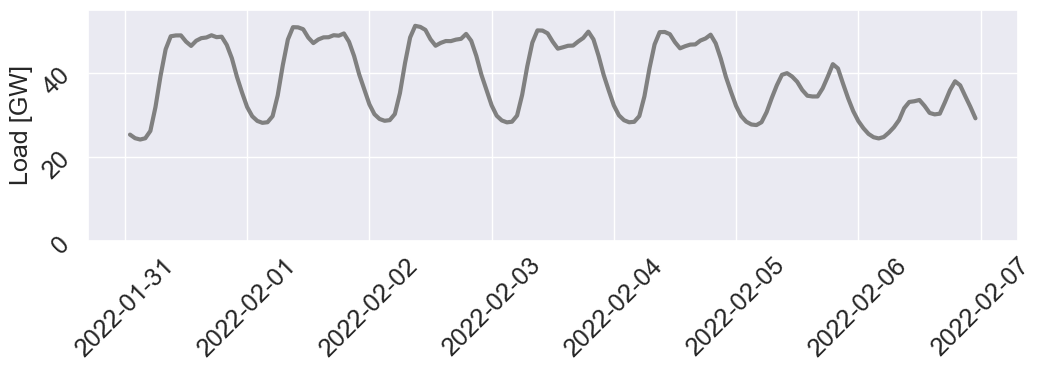

In [12]:
plot_aggregated_load(decomposed_load, period, time_column='datetime', y_label="Load [GW]", ylim=(0, 55), figsize=(12,3))

In [13]:
day_df = decompose_daily_consumption(C_ens, E)
day_df['Domestic'] = day_df['$S_1$'] + day_df['$S_2$']
day_df['Industry'] = day_df['$S_3$']
day_df['Services'] = day_df['$S_4$'] + day_df['$S_5$']
day_df.drop(columns=[f'$S_{k+1}$' for k in range(K)], inplace=True)
day_df['date'] = day_df['date'].astype('datetime64[ns]')
day_df

,model,date,zone,Domestic,Industry,Services
0,0,2021-01-01,Italy,321.428719,47.166828,244.273906
1,1,2021-01-01,Italy,321.771305,14.721201,276.135159
2,2,2021-01-01,Italy,234.314729,15.937776,362.247221
3,3,2021-01-01,Italy,360.681385,7.274812,244.404120
4,4,2021-01-01,Italy,307.676092,10.443864,294.688670
...,...,...,...,...,...,...
296740,266,2023-12-31,Italy,266.738008,22.834661,313.543355
296741,267,2023-12-31,Italy,300.203433,91.740656,211.193840
296742,268,2023-12-31,Italy,271.587620,26.522708,305.084356
296743,269,2023-12-31,Italy,323.986141,45.800406,233.235870


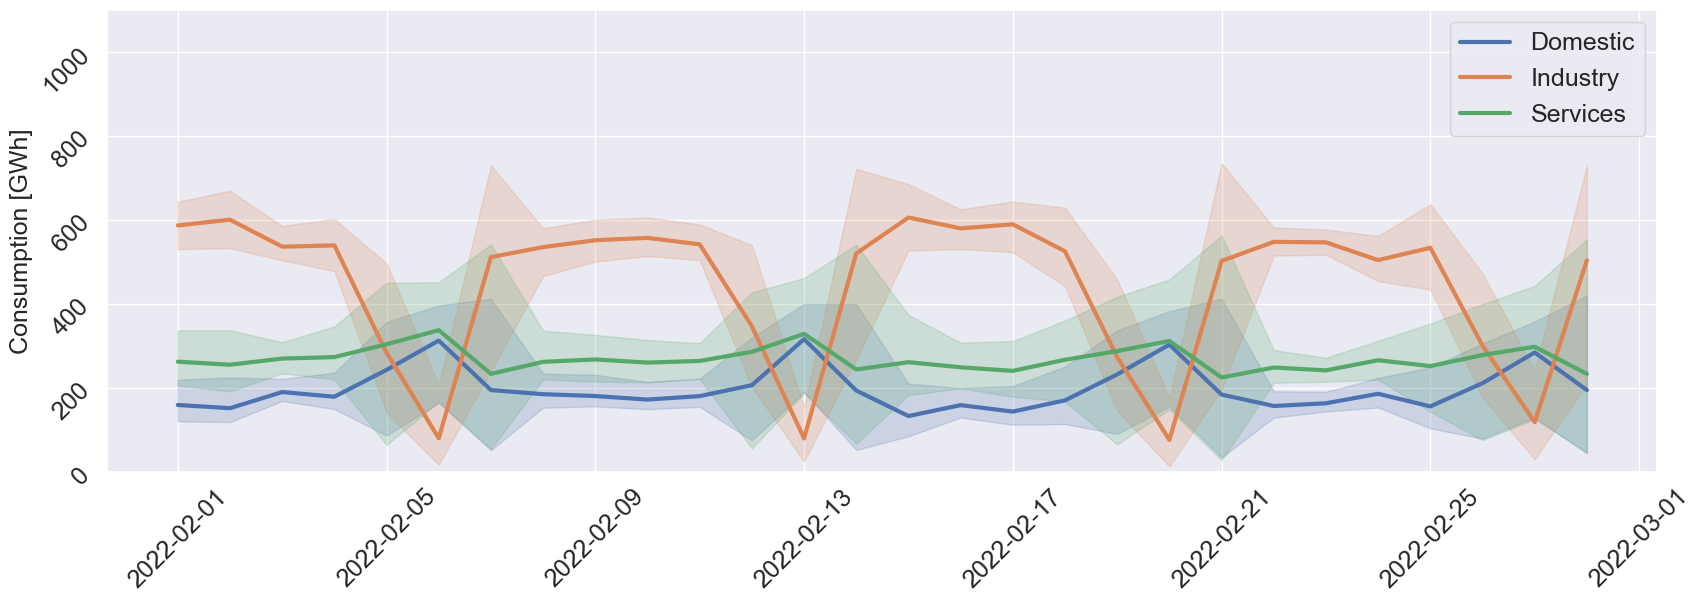

In [14]:
period = ["2022-02-01", "2022-02-28"]
plot_decomposed_load(day_df, period, time_column='date', y_label="Consumption [GWh]", ylim=(0, 1100))

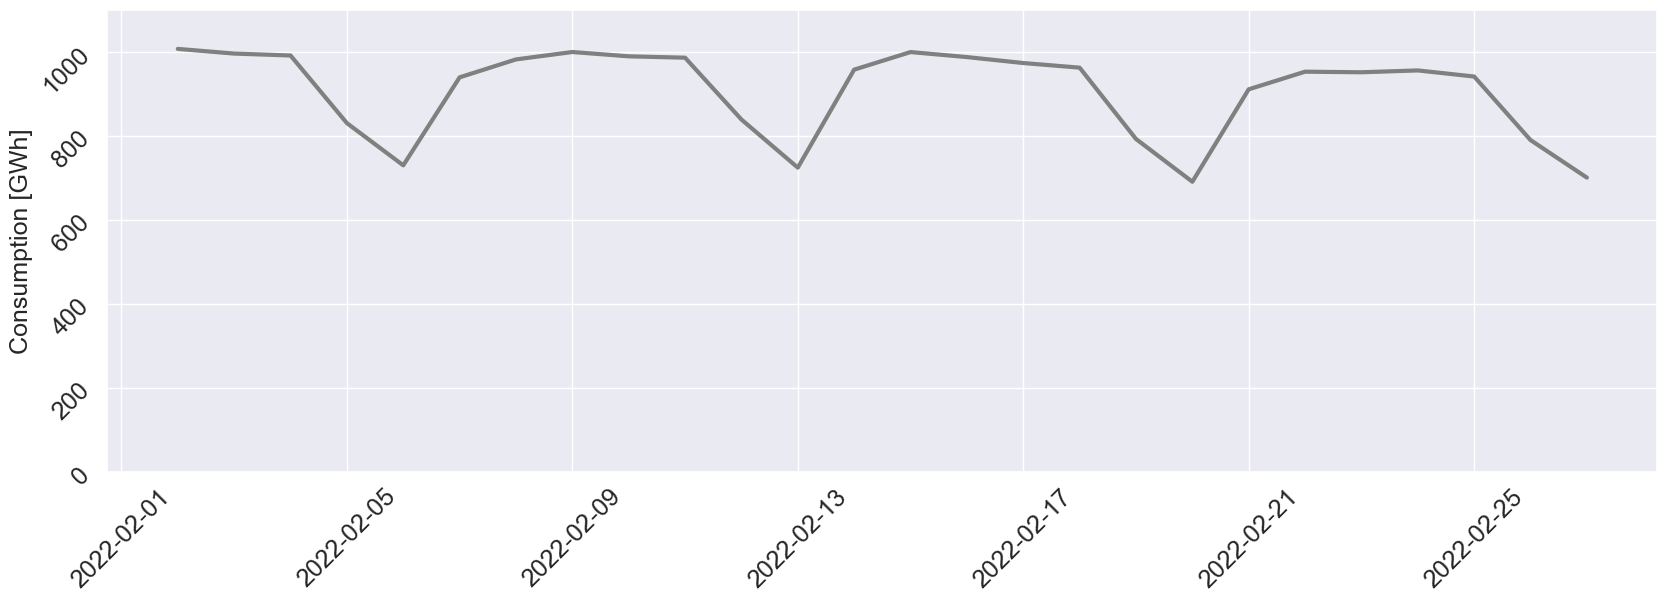

In [15]:
plot_aggregated_load(day_df, period, time_column='date', y_label="Consumption [GWh]", ylim=(0, 1100))

In [16]:
day_df['month'] = pd.to_datetime(day_df['date']).dt.to_period('M')

month_df = day_df.groupby(['month', 'zone', 'model'], as_index=False, sort=False)[sectors].sum()
month_df['year'] = month_df.month.dt.year
month_df

,month,zone,model,Domestic,Industry,Services,year
0,2021-01,Italy,0,6983.155453,11961.809806,8152.404428,2021
1,2021-01,Italy,1,7032.807582,11990.670384,8068.651446,2021
2,2021-01,Italy,2,7080.894040,11906.658060,8097.683975,2021
3,2021-01,Italy,3,7048.798767,11878.273997,8174.733808,2021
4,2021-01,Italy,4,7082.152249,11882.571970,8135.625019,2021
...,...,...,...,...,...,...,...
9751,2023-12,Italy,266,6114.742393,10655.465350,8040.853058,2023
9752,2023-12,Italy,267,6015.723919,11613.045794,7183.195754,2023
9753,2023-12,Italy,268,6132.052240,10778.273867,7900.309339,2023
9754,2023-12,Italy,269,6288.792241,10159.864908,8365.540309,2023


In [17]:
year_df = month_df.groupby(['zone', 'year', 'model'], as_index=False)[sectors].sum()
year_df

,zone,year,model,Domestic,Industry,Services
0,Italy,2021,0,71475.596371,151005.713847,97791.898148
1,Italy,2021,1,71585.819224,151034.828967,97644.049562
2,Italy,2021,2,71708.773741,150952.940330,97568.517520
3,Italy,2021,3,71363.216496,150878.519530,98024.107740
4,Italy,2021,4,71335.199685,150880.993404,98052.277253
...,...,...,...,...,...,...
808,Italy,2023,266,61967.145074,147568.311636,96643.856157
809,Italy,2023,267,63730.695214,146975.655613,95448.368104
810,Italy,2023,268,62006.224079,148726.075254,95434.218446
811,Italy,2023,269,63941.594208,140871.745791,101380.414440


## Test the monthly consumption decomposition with ASC and MSI

In [18]:
year_totals = unit_info.groupby('year')['cons'].sum()
year_month_totals = unit_info.groupby(['year', 'month'])['cons'].sum()

cons_df = process_sector_consumption(consumption_file, year_totals)
indics_df = get_indicators(imser_file, imcei_file, enel_files)
Y = get_Y(indics_df, cons_df, year_month_totals)
Y.head()

,Domestic,Industry,Services
Mese,,,
2021-01-01,7140.915027,11919.077661,8021.876794
2021-02-01,5798.208878,12027.588273,7152.953381
2021-03-01,6034.945900,13395.272065,7239.429554
2021-04-01,5426.688341,12536.637147,6532.997014
2021-05-01,4902.511816,13091.845812,6987.220874


In [19]:
Y_pred = month_df.copy()
Y_pred = Y_pred.groupby(['year', 'month', 'model'], as_index=False).sum().drop('zone', axis=1)
Y_pred['date'] = Y_pred.month.dt.to_timestamp()
Y_pred.drop(columns=['year', 'month'], inplace=True)
# Set the 'date' column as the index
Y_pred.set_index('date', inplace=True)
Y_pred

,model,Domestic,Industry,Services
date,,,,
2021-01-01,0,6983.155453,11961.809806,8152.404428
2021-01-01,1,7032.807582,11990.670384,8068.651446
2021-01-01,2,7080.894040,11906.658060,8097.683975
2021-01-01,3,7048.798767,11878.273997,8174.733808
2021-01-01,4,7082.152249,11882.571970,8135.625019
...,...,...,...,...
2023-12-01,266,6114.742393,10655.465350,8040.853058
2023-12-01,267,6015.723919,11613.045794,7183.195754
2023-12-01,268,6132.052240,10778.273867,7900.309339


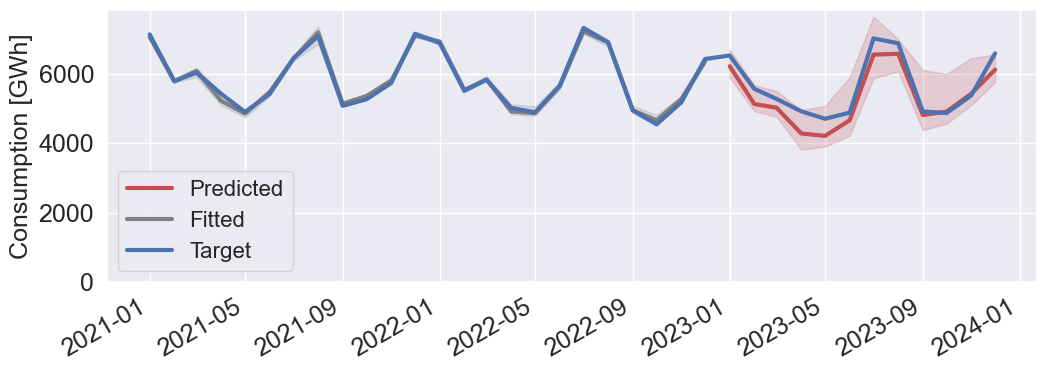

In [20]:
plot_monthly_cons(Y_pred, Y, "Domestic", train_months, test_months, linewidth=3, ylim={'bottom': 0})

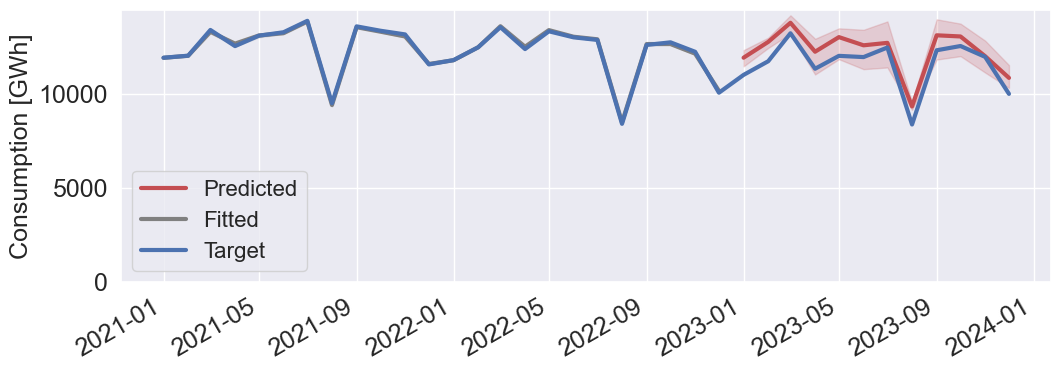

In [21]:
plot_monthly_cons(Y_pred, Y, "Industry", train_months, test_months, ylim={'bottom': 0})

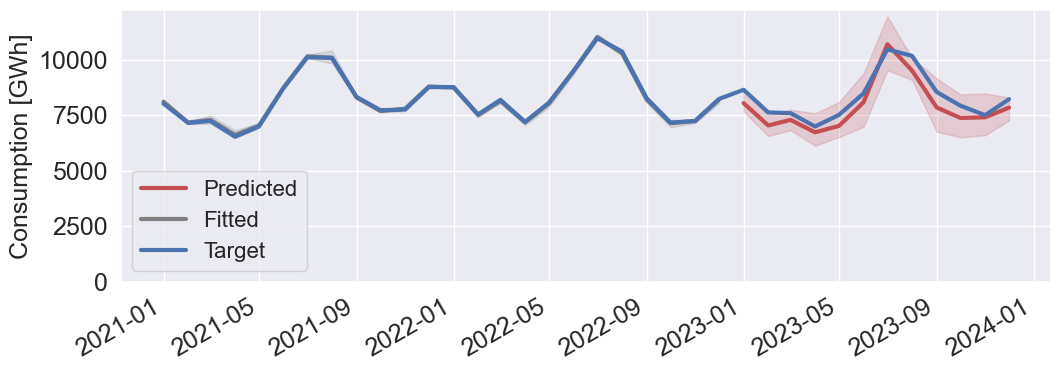

In [22]:
plot_monthly_cons(Y_pred, Y, "Services", train_months, test_months, ylim={'bottom': 0})

Test if the %YoY variations in the test set are consistent with those of the indicators, to show that we just don't catch some simple seaonality

In [23]:
Y_hat = Y_pred.groupby(Y_pred.index)[sectors].mean()
Y_hat.head()

,Domestic,Industry,Services
date,,,
2021-01-01,7066.478671,11914.831150,8109.517252
2021-02-01,5785.448642,12021.065703,7169.861053
2021-03-01,6084.359503,13297.716604,7291.009313
2021-04-01,5223.636647,12669.273203,6611.183019
2021-05-01,4855.840365,13102.175916,7030.226800


In [24]:
yoy_pred = Y_hat.pct_change(periods=12) * 100
yoy_pred_test = yoy_pred[yoy_pred.index.isin(test_months)]
yoy_pred_test

,Domestic,Industry,Services
date,,,
2023-01-01,-10.255665,1.146672,-8.022602
2023-02-01,-7.371688,2.287488,-6.224039
2023-03-01,-13.941484,1.350623,-10.449805
2023-04-01,-12.917715,-2.119311,-6.217726
2023-05-01,-13.484543,-2.781991,-12.568984
2023-06-01,-17.289545,-3.498464,-14.819607
2023-07-01,-9.283550,-1.471152,-3.016132
2023-08-01,-4.793605,9.967654,-7.489561
2023-09-01,-2.730973,3.675368,-4.382935


In [25]:
yoy_true = indics_df.pct_change(periods=12) * 100
yoy_true_test = yoy_true[yoy_true.index.isin(test_months)]
yoy_true_test

,IMCEI,IMSER,Enel
Mese,,,
2023-01-01,-8.473890,-2.871173,-8.698748
2023-02-01,-6.788000,0.713866,-1.582046
2023-03-01,-0.914706,-5.502422,-9.751816
2023-04-01,-9.089134,-3.063768,-4.350145
2023-05-01,-8.125113,-4.675995,-3.734658
2023-06-01,-5.778922,-8.022716,-13.110019
2023-07-01,-1.192687,-2.249073,-3.903441
2023-08-01,0.018503,-1.072174,-1.653867
2023-09-01,-0.939247,5.188813,-1.067821


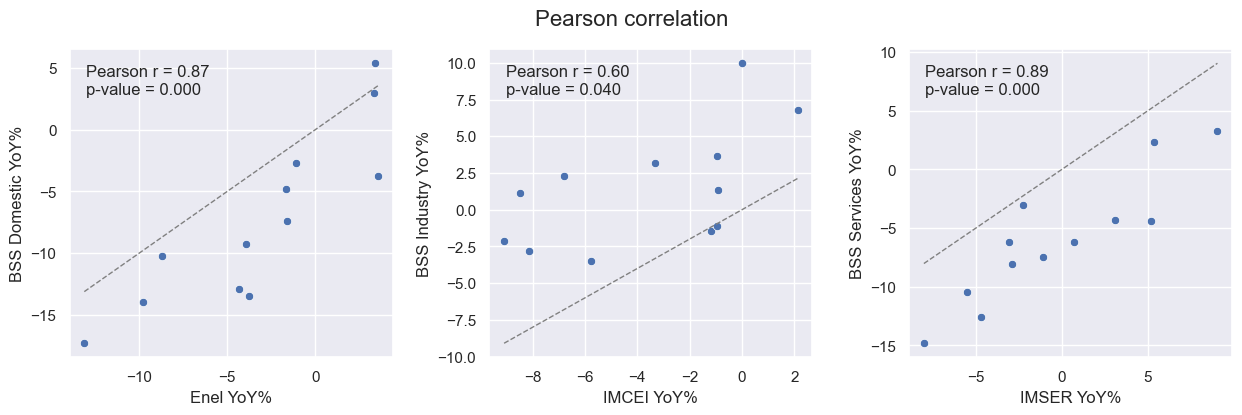

In [26]:
plot_correlation_yoy(yoy_true_test, yoy_pred_test, correlation='Pearson')

## Analyse sector load profiles

In [27]:
# Normalise the decomposed load to easily retrieve the profiles
D = get_D(p)
norms = decomposed_load.reset_index().groupby(['obs', 'model'], as_index=False, sort=False)[sectors].agg(lambda a: a.dot(D.squeeze()))
profiles = decomposed_load.copy()
profiles[sectors] = profiles[sectors] /  np.repeat(norms[sectors], repeats=p, axis=0)
profiles[unit_info.columns] = np.repeat(unit_info, repeats=p*N, axis=0)
profiles

,model,hour,obs,datetime,zone,Domestic,Industry,Services,date,region,year,month,daytype,cons,season
0,0,0.0,Italy_2021-01-01_Holiday,2021-01-01 00:00:00,Italy,0.058197,0.034319,0.019914,2021-01-01,Italy,2021,01,Holiday,612.349503,Winter
1,0,1.0,Italy_2021-01-01_Holiday,2021-01-01 01:00:00,Italy,0.053251,0.032094,0.019131,2021-01-01,Italy,2021,01,Holiday,612.349503,Winter
2,0,2.0,Italy_2021-01-01_Holiday,2021-01-01 02:00:00,Italy,0.050013,0.030875,0.018264,2021-01-01,Italy,2021,01,Holiday,612.349503,Winter
3,0,3.0,Italy_2021-01-01_Holiday,2021-01-01 03:00:00,Italy,0.047948,0.030432,0.017470,2021-01-01,Italy,2021,01,Holiday,612.349503,Winter
4,0,4.0,Italy_2021-01-01_Holiday,2021-01-01 04:00:00,Italy,0.046643,0.030433,0.017420,2021-01-01,Italy,2021,01,Holiday,612.349503,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7418620,270,20.0,Italy_2023-12-31_Holiday,2023-12-31 20:00:00,Italy,0.052711,0.045140,0.046657,2023-12-31,Italy,2023,12,Holiday,602.807502,Fall
7418621,270,21.0,Italy_2023-12-31_Holiday,2023-12-31 21:00:00,Italy,0.046654,0.042475,0.046291,2023-12-31,Italy,2023,12,Holiday,602.807502,Fall
7418622,270,22.0,Italy_2023-12-31_Holiday,2023-12-31 22:00:00,Italy,0.043652,0.037690,0.043420,2023-12-31,Italy,2023,12,Holiday,602.807502,Fall
7418623,270,23.0,Italy_2023-12-31_Holiday,2023-12-31 23:00:00,Italy,0.040008,0.034327,0.039868,2023-12-31,Italy,2023,12,Holiday,602.807502,Fall


In [28]:
profiles_ens = profiles.groupby(unit_info.columns.to_list() + ['model', 'hour'], as_index=False, sort=False)[sectors].mean()
profiles_ens

,region,year,month,daytype,cons,season,model,hour,Domestic,Industry,Services
0,Italy,2021,01,Holiday,612.349503,Winter,0,0.0,0.058197,0.034319,0.019914
1,Italy,2021,01,Holiday,612.349503,Winter,0,1.0,0.053251,0.032094,0.019131
2,Italy,2021,01,Holiday,612.349503,Winter,0,2.0,0.050013,0.030875,0.018264
3,Italy,2021,01,Holiday,612.349503,Winter,0,3.0,0.047948,0.030432,0.017470
4,Italy,2021,01,Holiday,612.349503,Winter,0,4.0,0.046643,0.030433,0.017420
...,...,...,...,...,...,...,...,...,...,...,...
7418620,Italy,2023,12,Holiday,602.807502,Fall,270,20.0,0.052711,0.045140,0.046657
7418621,Italy,2023,12,Holiday,602.807502,Fall,270,21.0,0.046654,0.042475,0.046291
7418622,Italy,2023,12,Holiday,602.807502,Fall,270,22.0,0.043652,0.037690,0.043420
7418623,Italy,2023,12,Holiday,602.807502,Fall,270,23.0,0.040008,0.034327,0.039868


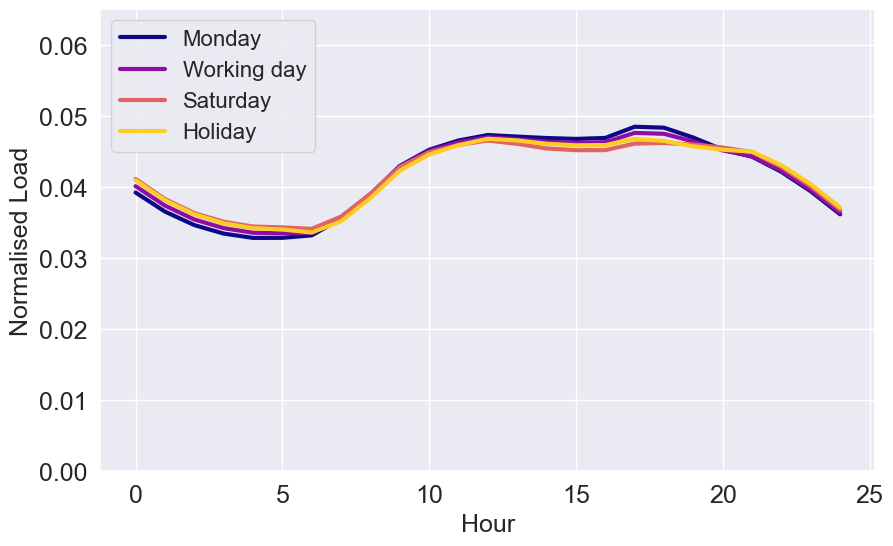

In [32]:
sector = 'Services'
hue = 'daytype'

palette = {
    'season': ['#77dd77', '#ffdb58', '#FF8C00', '#4682B4'],
    'daytype': [plasma(value) for value in np.linspace(0, 0.9, 4)]
}

plot_profiles(profiles_ens, sector, hue, palette=palette[hue])

## Export results

In [94]:
Y_pred_test = Y_pred[Y_pred.index.isin(test_months)]
Y_hat_test = Y_hat[Y_hat.index.isin(test_months)]
Y_hat_test.to_csv('data/sector_monthly_cons_mean.csv')
Y_pred_test.to_csv('data/sector_monthly_cons_distrib.csv')

<HR>

# TESTS